# EMNIST-GAN
so, I once answered a lecturer (Mr Percy Wong) to train a 5 year old how to recognize digits, I will use a GAN.

so let's use a GAN.

In this notebook, I will be making use of the EMNIST (Extended Modified NIST) dataset of handwritten digits AND alphabets to train a Generator and Discriminator. The use-case for this would be to solve captchas but primarily to settle that statement that I said about GANs a long time ago.

# ------ DANGER ZONE ------k
## DO NOT RUN THE NEXT CELL IF YOU DON'T INTEND TO PIP INSTALL

In [1]:
!pip3 install extra_keras_datasets
!pip3 install tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [2]:
import pandas as pd
import os
from extra_keras_datasets import emnist
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.initializers import glorot_normal, RandomNormal, Zeros
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from tensorflow import keras
import numpy as np
from livelossplot import PlotLossesKeras
import random
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt

from collections import Counter

Download the dataset byclass for EMNIST, change the dataset and labels here if you wish (there is EMNIST for japanese characters too!)

In [3]:
(x_train, y_train), (x_test, y_test) = emnist.load_data(type='byclass')

INFO:root:Loading dataset = emnist


## Dataset classes
These are the labels of our dataset, we'll use this to convert it from the result to the actual human-readable class

In [4]:
class_idx = ['0','1','2','3','4','5','6','7','8','9',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

## Load samples
Let's take some samples from our dataset and take a look at them.

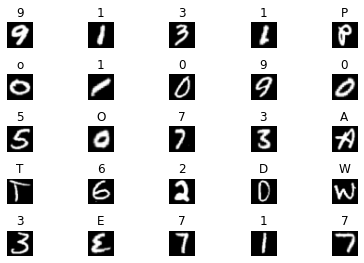

In [5]:
for i in range(25):
    # pick random image index from dataset to show
    index = random.randint(0, len(x_train))
    # define subplot
    plt.subplot(5, 5, 1 + i)
    plt.tight_layout()
    # turn off axis
    plt.axis('off')
    # change to grayscale as our images are in grayscale
    plt.imshow(x_train[index], cmap='gray')
    # show image title according to the real dataset classes
    plt.title(class_idx[y_train[index]])

## Reshape the data for training
Reshape x to 28,28,1 to include the colour channel and perform one hot encoding on y

In [6]:
# add an additional column for channels (our images are grayscale, so 1) and convert to float32
x_train = np.expand_dims(x_train, axis=-1).astype("float16")
x_test = np.expand_dims(x_test, axis=-1).astype("float16")
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)

Train (697932, 28, 28, 1) (697932, 62)
Test (116323, 28, 28, 1) (116323, 62)


## Create the discriminator network
I will be using SimpleNet for its simplicity and high accuracy.
GANs take forever to train, every bit of performance is welcome. SimpleNet is also impressively accurate

model I built below is based off the pytorch model with LeakyReLU

SimpleNet paper : https://arxiv.org/abs/1608.06037

In [7]:
discriminator_model = Sequential(name="SimpleNetV1")
discriminator_model.add(Input(shape=(28,28,1)))
# Block 1
discriminator_model.add(Conv2D(64, (3,3), padding='same', kernel_initializer=glorot_normal()))
discriminator_model.add(BatchNormalization())
discriminator_model.add(LeakyReLU())

# Block 2,3,4 (repeated)
for i in range(3):
    discriminator_model.add(Conv2D(128, (3,3), padding="same", kernel_initializer=RandomNormal(stddev=0.01)))
    discriminator_model.add(BatchNormalization())
    discriminator_model.add(LeakyReLU())

# max pooling (change strides as you wish)
discriminator_model.add(MaxPooling2D(pool_size=(2,2), strides=2))
discriminator_model.add(Dropout(0.2))

# Block 5,6
for i in range (2):
    discriminator_model.add(Conv2D(128, (3,3), padding="same", kernel_initializer=RandomNormal(stddev=0.01)))
    discriminator_model.add(BatchNormalization())
    discriminator_model.add(LeakyReLU())

# Block 7
discriminator_model.add(Conv2D(256, (3,3), padding="same", kernel_initializer=glorot_normal()))
discriminator_model.add(BatchNormalization())
discriminator_model.add(LeakyReLU())
# Another max pooling
discriminator_model.add(MaxPooling2D(pool_size=(2,2), strides=2))
discriminator_model.add(Dropout(0.2))


# Block 8,9
for i in range(2):
    discriminator_model.add(Conv2D(256, (3,3), padding="same", kernel_initializer=glorot_normal()))
    discriminator_model.add(BatchNormalization())
    discriminator_model.add(LeakyReLU())

# Block 10
discriminator_model.add(Conv2D(512, (3,3), padding="same", kernel_initializer=glorot_normal()))
discriminator_model.add(BatchNormalization())
discriminator_model.add(LeakyReLU())

# Block 11
discriminator_model.add(Conv2D(2048, (1,1), padding="same", kernel_initializer=glorot_normal()))
discriminator_model.add(BatchNormalization())
discriminator_model.add(LeakyReLU())

# Block 12
discriminator_model.add(Conv2D(256, (1,1), padding="same", kernel_initializer=glorot_normal()))
discriminator_model.add(BatchNormalization())
discriminator_model.add(LeakyReLU())
# Another another another max pooling
discriminator_model.add(MaxPooling2D(pool_size=(2,2), strides=2))
discriminator_model.add(Dropout(0.2))

# Block 13
discriminator_model.add(Conv2D(256, (3,3), padding="same", kernel_initializer=glorot_normal()))
discriminator_model.add(BatchNormalization())
discriminator_model.add(LeakyReLU())
# Another another another max pooling
discriminator_model.add(MaxPooling2D(pool_size=(2,2), strides=2))
discriminator_model.add(Dropout(0.2))

# Classifier
discriminator_model.add(Flatten())
# softmax performs better with multiple classes
# final output dense layer
discriminator_model.add(Dense(len(class_idx), activation="softmax"))
# standard stuff
discriminator_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# summarize for jupyter
discriminator_model.summary()

Model: "SimpleNetV1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       

## Configure the image augmentation

In [8]:
datagen = ImageDataGenerator(rotation_range=20)
it = datagen.flow(x_train, y_train)

## Train the model
generate_real_samples will take random samples from the training set with its label.
generate_fake_samples will

In [9]:
mixed_precision.set_global_policy('mixed_float16')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
history = discriminator_model.fit(it, epochs=30, batch_size=64)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6


Num GPUs Available:  1
Epoch 1/30
21811/21811 [==============================] - 231s 10ms/step - loss: 0.6549 - accuracy: 0.7879
Epoch 2/30
21811/21811 [==============================] - 226s 10ms/step - loss: 0.4097 - accuracy: 0.8508
Epoch 3/30
21811/21811 [==============================] - 227s 10ms/step - loss: 0.3833 - accuracy: 0.8588
Epoch 4/30
21811/21811 [==============================] - 227s 10ms/step - loss: 0.3714 - accuracy: 0.8618
Epoch 5/30
21811/21811 [==============================] - 226s 10ms/step - loss: 0.3618 - accuracy: 0.8647
Epoch 6/30
21811/21811 [==============================] - 226s 10ms/step - loss: 0.3564 - accuracy: 0.8662
Epoch 7/30
21811/21811 [==============================] - 226s 10ms/step - loss: 0.3505 - accuracy: 0.8681
Epoch 8/30
21811/21811 [==============================] - 226s 10ms/step - loss: 0.3455 - accuracy: 0.8695
Epoch 9/30
21811/21811 [==============================] - 226s 10ms/step - loss: 0.3421 - accuracy: 0.8709
Epoch 10/30
21

In [10]:
from keras.models import load_model
score = discriminator_model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

3636/3636 [==============================] - 14s 4ms/step - loss: 0.3316 - accuracy: 0.8763
Test loss: 0.33160221576690674
Test accuracy: 0.876258373260498


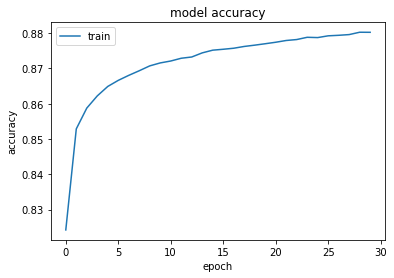

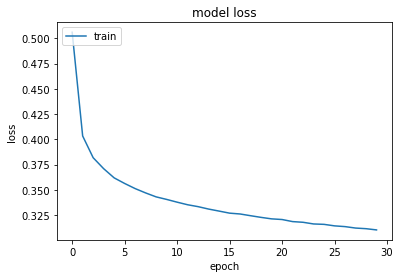

In [11]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [12]:
discriminator_model.save("aaaaav3.h5")
